In [38]:
# 1. Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from pymc_extras.statespace.core.statespace import PyMCStateSpace
import pytensor.tensor as pt
import pymc as pm
import pytensor

In [39]:
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]


def print_model_ssm(mod, how="eval"):
    nice_heading = f'{"name":<20}{"__repr__":<50}{"shape":<10}{"value":<20}'
    print(nice_heading)
    print("=" * len(nice_heading))
    if how == "eval":
        matrices = [x.eval() for x in mod._unpack_statespace_with_placeholders()]
    elif how == "draw":
        matrices = pm.draw(mod.unpack_statespace())

    for name, value in zip(matrix_names, matrices):
        repr_ = str(mod.ssm[name])
        shape = str(mod.ssm[name].type.shape)
        value = str(value).replace("\n ", "\n" + " " * 81)
        print(f"{name:<20}{repr_:<50}{shape:<10}{value:<20}")
        print("-" * len(nice_heading))

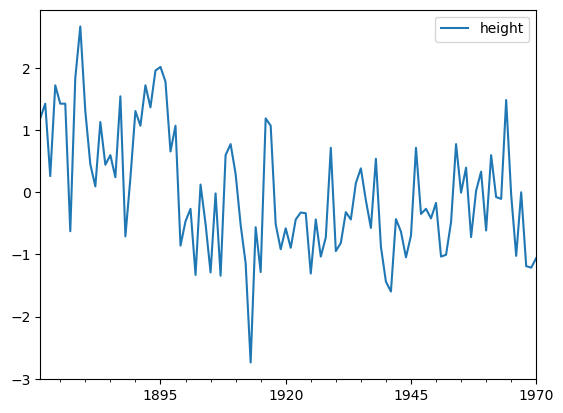

In [40]:

nile = pd.read_csv("/Users/andrea/Desktop/gitProject/pymc-extras/tests/statespace/test_data/nile.csv", dtype={"x": "float64"})
nile.index = pd.date_range(start="1871-01-01", end="1970-01-01", freq="YS-JAN")
nile.rename(columns={"x": "height"}, inplace=True)
nile = (nile - nile.mean()) / nile.std()
nile.plot();

In [41]:
nile.shape

(100, 1)

## Custom (PyTensor) Kalman Filter on Univariate Structural model

In [42]:
c = pt.as_tensor_variable([0.0, 0.0])      
d = pt.as_tensor_variable([0.0])           
Z = pt.as_tensor_variable([[1.0, 0.0]])    
T = pt.as_tensor_variable([[1.0, 1.0],
                           [0.0, 1.0]])     
R = pt.as_tensor_variable([[1.0, 0.0],
                           [0.0, 1.0]])     

First attempt with arbitrage selection of parameters for sigmas

In [43]:
x0 = pt.zeros(2)            # Assume initial state is zero
P0 = pt.eye(2)              # Moderate confidence in initial state
H = pt.eye(1) * 0.1         # Small measurement noise
Q = pt.eye(2) * 0.01        # Small process noise

In [44]:
def predict(a, P, c, T, R, Q):
    # state prediction
    a_hat = T @ a + c
    # covariance prediction
    P_hat = T @ P @ T.T + R @ Q @ R.T

    return a_hat, P_hat

def update(a, P, y, c, d, Z, H):
    
    # Forecast observation
    y_hat = d + Z.dot(a)
    # residual calculation
    v = y - y_hat # how surprising the actual observation is compared to what we expected.



    # innovation covariance
    PZT = P.dot(Z.T)
    F = Z.dot(PZT) + H # uncertainty in our predicted observation

    # F_inv = pt.linalg.inv(F)
    # Kalman gain calculation
    # K = PZT.dot(F_inv)
    K= pt.linalg.solve(F, PZT.T).T          # how much to trust the observation versus the prior state
    I_KZ = pt.eye(a.shape[0]) - K.dot(Z)

    # Update state estimate
    a_filtered = a + K.dot(v)   # how to adjust our state based on the observation, scaled by K
    # Updated state covariance 
    P_filtered = I_KZ @P @ I_KZ.T + K @ H @ K.T # updated uncertainty in your state estimate

    # Log-likelihood calculation
    # inner_term = v.T @ F_inv @ v
    # _, F_logdet = pt.linalg.slogdet(F)

    # ll = -0.5 * (pt.log(2 * pt.constant(np.pi, dtype="float64")) + F_logdet + inner_term).ravel()[0]

    return a_filtered, P_filtered, y_hat, F, K #, ll

def kalman_step(y, a, P, c, d, T, Z, R, H, Q ):
    a_filtered, P_filtered, obs_mu, obs_cov, K = update(y=y, a=a, c=c, d=d, P=P, Z=Z, H=H)
    a_hat, P_hat = predict(a=a_filtered, P=P_filtered, c=c, T=T, R=R, Q=Q)

    return (a_filtered, a_hat, obs_mu, P_filtered, P_hat, obs_cov, K)



In [45]:
nile_pt = pt.as_tensor_variable(nile.values)

In [46]:
results, updates = pytensor.scan(
    kalman_step,
    sequences=[nile_pt],
    outputs_info=[None, x0, None, None, P0, None, None],
    non_sequences=[c, d, T, Z, R, H, Q],
    strict=False,
    )

In [47]:
results

[Scan{scan_fn, while_loop=False, inplace=none}.2,
 Subtensor{start:}.0,
 Scan{scan_fn, while_loop=False, inplace=none}.3,
 Scan{scan_fn, while_loop=False, inplace=none}.4,
 Subtensor{start:}.0,
 Scan{scan_fn, while_loop=False, inplace=none}.5,
 Scan{scan_fn, while_loop=False, inplace=none}.6]

In [48]:
for i, r in enumerate(results):
    print(f"results[{i}].shape =", r.shape.eval() if hasattr(r, 'eval') else r.shape)


results[0].shape = [100   2]
results[1].shape = [100   2]
results[2].shape = [100   1]
results[3].shape = [100   2   2]
results[4].shape = [100   2   2]
results[5].shape = [100   1   1]
results[6].shape = [100   2   1]


In [49]:
kalman_gain = results[6].eval()
a_filtered = results[0].eval()  # shape: (T, k_states)
y_pred = results[2].eval()      # predicted observations

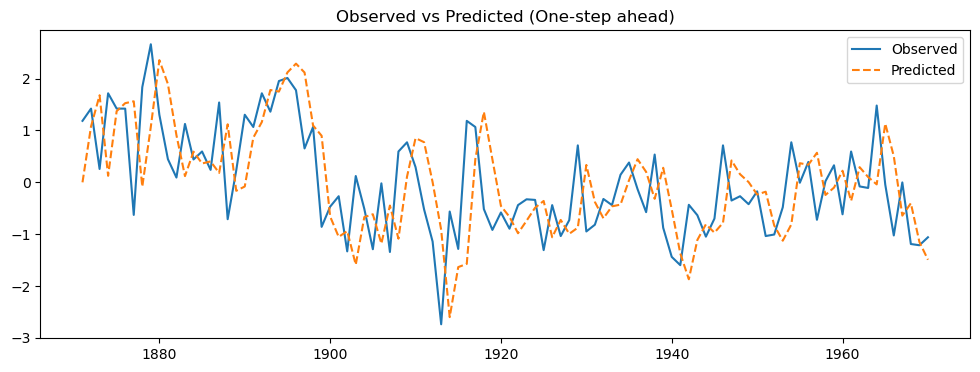

In [50]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(nile.index, nile.values, label="Observed")
plt.plot(nile.index, y_pred.ravel(), label="Predicted", linestyle="--")
plt.title("Observed vs Predicted (One-step ahead)")
plt.legend()
plt.show()

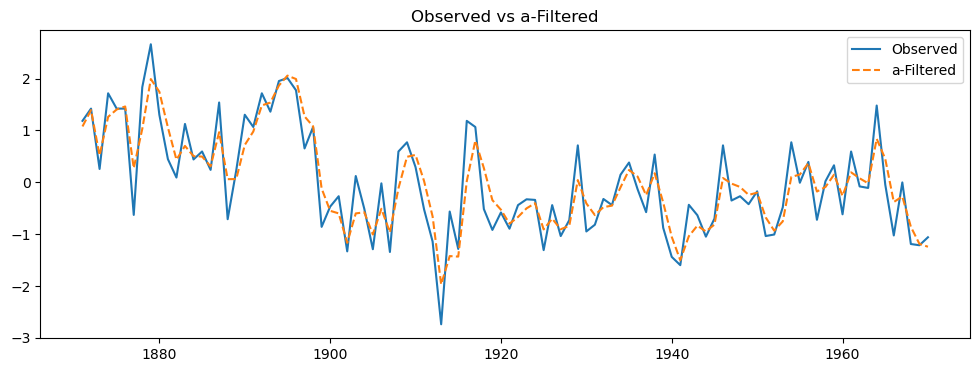

In [51]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(nile.index, nile.values, label="Observed")
plt.plot(nile.index, a_filtered[:,0].ravel(), label="a-Filtered", linestyle="--")
plt.title("Observed vs a-Filtered")
plt.legend()
plt.show()

## PyMC Kalman Filter on Univariate Structural model

In [52]:
class UnivariateStructural(PyMCStateSpace):
    def __init__(self):
        k_states = 2    
        k_posdef = 2     
        k_endog = 1     

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

    def make_symbolic_graph(self):

        # Initial state mean and covariance
        x0 = self.make_and_register_variable("x0", shape=(self.k_states,))
        P0 = self.make_and_register_variable("P0", shape=(self.k_states, self.k_states))

        # State innovation std dev (Q) 
        sigma_eta1 = self.make_and_register_variable("sigma_eta1", shape=())
        sigma_eta2 = self.make_and_register_variable("sigma_eta2", shape=())

        # Observation noise std dev (H)
        sigma_eps = self.make_and_register_variable("sigma_eps", shape=())

        # Design matrix Z: y_t = mu_t + eps_t
        self.ssm["design", :, :] = pt.zeros((self.k_endog, self.k_states))
        self.ssm["design", 0, 0] = 1.0

        # Transition matrix T: mu_t = mu_{t-1} + eta_t
        self.ssm["transition", 1, 0] = 0.0
        self.ssm["transition", 0, 0] = 1.0
        self.ssm["transition", 0, 1] = 1.0
        self.ssm["transition", 1, 1] = 1.0

        # Selection matrix R: state noise enters directly
        self.ssm["selection", :, :] = pt.eye(self.k_states)

        # State covariance Q
        self.ssm["state_cov", 0, 0] = sigma_eta1**2
        self.ssm["state_cov", 1, 0] = 0.0
        self.ssm["state_cov", 0, 1] = 0.0
        self.ssm["state_cov", 1, 1] = sigma_eta2**2

        # Observation noise covariance H
        self.ssm["obs_cov", 0, 0] = sigma_eps**2 

        # Initial conditions
        self.ssm["initial_state", :] = x0
        self.ssm["initial_state_cov", :, :] = P0

    @property
    def param_names(self):
        return ["x0", "P0", "sigma_eta1", "sigma_eta2", "sigma_eps"]


In [53]:
UniStruct = UnivariateStructural()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance (scalar level component)
    x0 = pm.Deterministic("x0", pt.zeros(2))
    P0 = pm.Deterministic("P0", pt.eye(2))

    # Process noise (random walk innovation)
    sigma_eta1 = pm.HalfNormal("sigma_eta1", sigma=1.0)
    sigma_eta2 = pm.HalfNormal("sigma_eta2", sigma=1.0)

    # Observation noise
    sigma_eps = pm.HalfNormal("sigma_eps", sigma=1.0)

    # Build symbolic graph using JAX backend
    UniStruct.build_statespace_graph(
        data=nile_pt,
        mode="JAX",
        save_kalman_filter_outputs_in_idata=True
    )


In [54]:
print_model_ssm(UniStruct, "draw")

name                __repr__                                          shape     value               
initial_state       initial_state                                     (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (2, 2)    [[1. 0.]
                                                                                 [0. 1.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (2,)      [0. 0.]             
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
----------------------------------------------------------------------------------------------------
transition   

In [55]:
import pymc_extras as pmx

In [56]:
UniStruct = UnivariateStructural()

with pm.Model() as pymc_mod:
    # Initial state mean and covariance (scalar level component)
    x0 = pm.Deterministic("x0", pt.zeros(2))
    P0 = pm.Deterministic("P0", pt.eye(2))

    # Process noise (random walk innovation)
    sigma_eta1 = pm.HalfNormal("sigma_eta1", sigma=1.0)
    sigma_eta2 = pm.HalfNormal("sigma_eta2", sigma=1.0)

    # Observation noise
    sigma_eps = pm.HalfNormal("sigma_eps", sigma=1.0)

    # Build symbolic graph
    UniStruct.build_statespace_graph(data=nile_pt, mode="jax")
    # idata= pmx.fit_laplace(compile_kwargs={'mode':'JAX'} ,
    #                         gradient_backend='jax')
    idata = pm.sample(
        draws=1000,
        chains=4,
        nuts_sampler="nutpie",
        nuts_sampler_kwargs={"backend": "jax", "gradient_backend": "jax"},
    )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.71,7
,2000,0,0.74,3
,2000,0,0.82,7
,2000,1,0.74,3


In [57]:
#idata.to_netcdf("KFSampleNutpie.nc")

In [58]:
idata = az.from_netcdf("KFSampleNutpie.nc")

<Axes: >

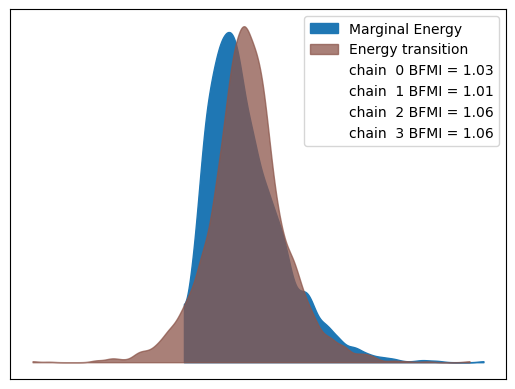

In [59]:
az.plot_energy(idata)

In [60]:
with pm.Model() as index_mod:
    UniStruct._build_dummy_graph()
    UniStruct._insert_random_variables()
    x0, P0, C, D, T, Z, R, H, Q = matrices = UniStruct.unpack_statespace()

    design = Z
    print(design)
    transition = T
    UniStruct.build_statespace_graph(data=nile_pt, mode="JAX", save_kalman_filter_outputs_in_idata=True)
    predicted_covariance = index_mod["predicted_covariance"]
    filtered_state = index_mod["filtered_state"]

    # attention to the order  
    def step(P, Z, T, H):
        PZT = pt.dot(P, Z.T)
        F = Z.dot(PZT) + H + pt.eye(H.shape[0]) * 1e-6
        
        K = pt.linalg.solve(F, PZT.T, assume_a="pos", check_finite=False).T 
        # K = pt.linalg.solve(F, pt.dot(T, PZT).T, assume_a="pos", check_finite=False).T 
        return K
    

    ss_kalman_gain, updates = pytensor.scan(step, non_sequences=[Z, T, H], 
                                           sequences=[predicted_covariance])
    
    pm.Deterministic("kalman_gain", ss_kalman_gain)
    kalman_gain_idata=pm.sample_posterior_predictive(idata, var_names=["kalman_gain"])
    filtered_state_idata=pm.sample_posterior_predictive(idata, var_names=["filtered_state"])
    predicted_state_idata=pm.sample_posterior_predictive(idata, var_names=["predicted_state"])



design


Sampling: []


Output()

Sampling: []


Output()

Sampling: []


Output()

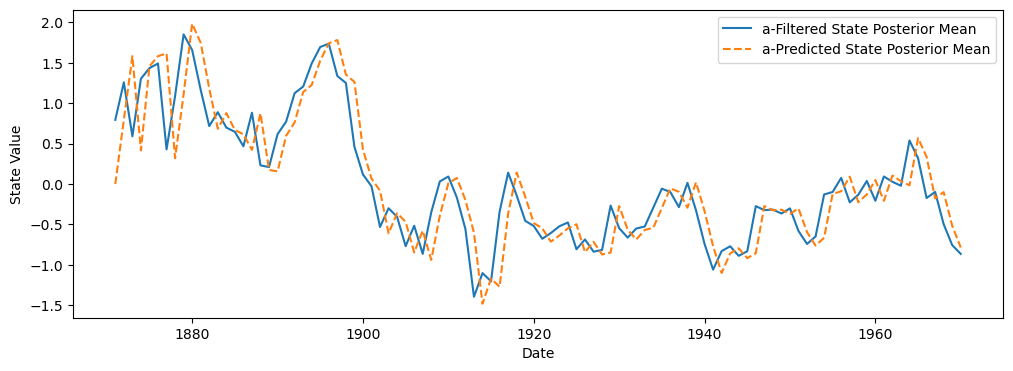

In [61]:
# Extract posterior predictive samples
state_samples = filtered_state_idata.posterior_predictive["filtered_state"].values  
pred_states_samples = predicted_state_idata.posterior_predictive["predicted_state"].values

# Select the first state (index 0)
state_0_samples = state_samples[:, :, :, 0]  
pred_0_states_samples = pred_states_samples[:, :, :, 0]

# Average over chains and draws to get posterior mean for each time point
state_mean_pymc = state_0_samples.mean(axis=(0, 1))  
pred_state_mean_pymc = pred_0_states_samples.mean(axis=(0, 1))  


fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(nile.index, state_mean_pymc, label="a-Filtered State Posterior Mean")
ax.plot(nile.index, pred_state_mean_pymc, label="a-Predicted State Posterior Mean", linestyle="--")
ax.set_xlabel("Date")
ax.set_ylabel("State Value")
ax.legend()
plt.show()

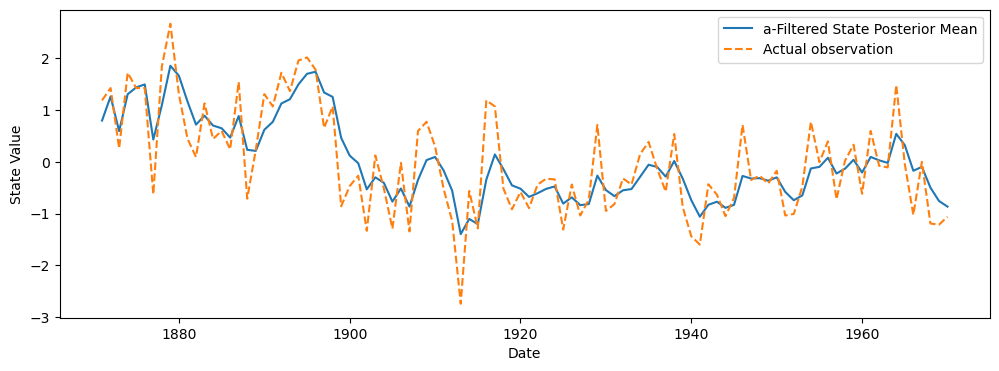

In [62]:
# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(nile.index, state_mean_pymc, label="a-Filtered State Posterior Mean")
ax.plot(nile.index, nile.values, label="Actual observation", linestyle="--")
ax.set_xlabel("Date")
ax.set_ylabel("State Value")
ax.legend()
plt.show()

## Custom (PyTensor) Kalman Filter on Univariate Structural model

In [63]:
c = pt.as_tensor_variable([0.0, 0.0])      
d = pt.as_tensor_variable([0.0])           
Z = pt.as_tensor_variable([[1.0, 0.0]])    
T = pt.as_tensor_variable([[1.0, 1.0],
                           [0.0, 1.0]])     
R = pt.as_tensor_variable([[1.0, 0.0],
                           [0.0, 1.0]])     

In [64]:
x0 = pt.zeros(2)            # Assume initial state is zero
P0 = pt.eye(2)              # Moderate confidence in initial state

In [65]:
# Getting posterior means of the sigma parameters from PyMC
sigma_eta1_mean = idata.posterior["sigma_eta1"].mean().item()
sigma_eta2_mean = idata.posterior["sigma_eta2"].mean().item()
sigma_eps_mean = idata.posterior["sigma_eps"].mean().item()

print(f"PyMC Posterior Mean sigma_eta1: {sigma_eta1_mean:.4f}")
print(f"PyMC Posterior Mean sigma_eta2: {sigma_eta2_mean:.4f}")
print(f"PyMC Posterior Mean sigma_eps: {sigma_eps_mean:.4f}")

PyMC Posterior Mean sigma_eta1: 0.2959
PyMC Posterior Mean sigma_eta2: 0.0141
PyMC Posterior Mean sigma_eps: 0.7025


In [66]:
H_comp = pt.eye(1) * (sigma_eps_mean**2)
Q_comp = pt.eye(2)
Q_comp = pt.set_subtensor(Q_comp[0, 0], sigma_eta1_mean**2)
Q_comp = pt.set_subtensor(Q_comp[1, 1], sigma_eta2_mean**2)

In [67]:
results_comp, updates_comp = pytensor.scan(
    kalman_step,
    sequences=[nile_pt],
    outputs_info=[None, x0, None, None, P0, None, None],
    non_sequences=[c, d, T, Z, R, H_comp, Q_comp], 
    strict=False,
)

In [ ]:
a_filtered_comp = results_comp[0].eval()  
y_pred_comp = results_comp[2].eval()      
kalman_gain_comp = results_comp[6].eval() 

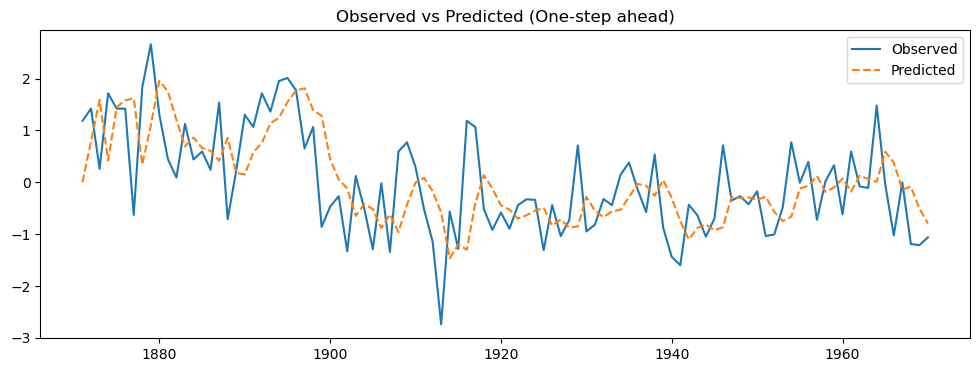

In [69]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(nile.index, nile.values, label="Observed")
plt.plot(nile.index, y_pred_comp.ravel(), label="Predicted", linestyle="--")
plt.title("Observed vs Predicted (One-step ahead)")
plt.legend()
plt.show()

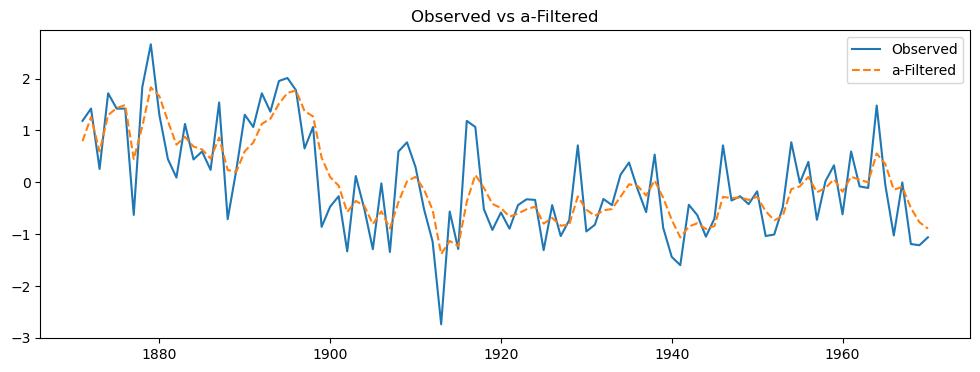

In [70]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(nile.index, nile.values, label="Observed")
plt.plot(nile.index, a_filtered_comp[:,0].ravel(), label="a-Filtered", linestyle="--")
plt.title("Observed vs a-Filtered")
plt.legend()
plt.show()

## Comparison

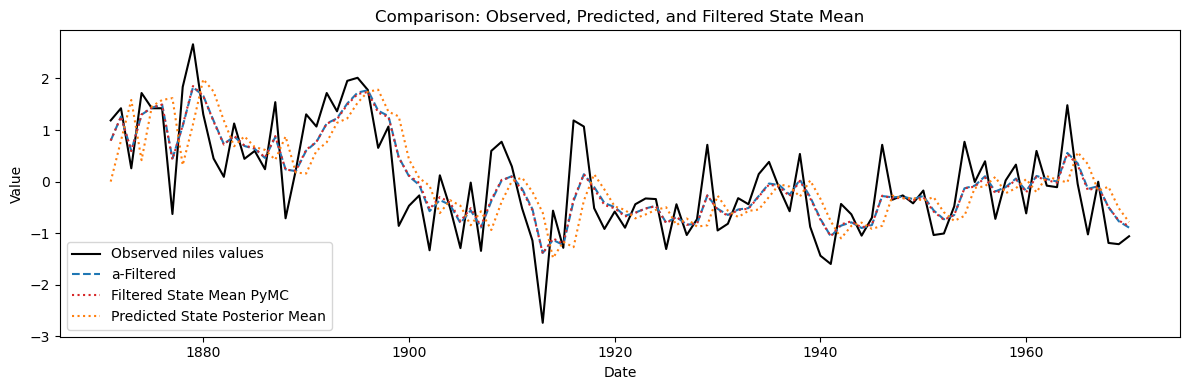

In [71]:

fig, ax = plt.subplots(figsize=(12, 4))

# Plot observed data
ax.plot(nile.index, nile.values, label="Observed niles values", color="black", linewidth=1.5)

# Plot a-Filtered state
ax.plot(nile.index, a_filtered_comp[:,0].ravel(), label="a-Filtered", linestyle="--")

# Plot posterior mean of the latent state
ax.plot(nile.index, state_mean_pymc, label="Filtered State Mean PyMC", linestyle=":", color="tab:red")

# Plot posterior mean of the predicted state
ax.plot(nile.index, pred_state_mean_pymc, label="Predicted State Posterior Mean", linestyle=":", color="tab:orange")

# Customize plot
ax.set_title("Comparison: Observed, Predicted, and Filtered State Mean")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend()
plt.tight_layout()
plt.show()


In [72]:
# Extract posterior predictive samples
kalman_samples = kalman_gain_idata.posterior_predictive["kalman_gain"].values  

# Average over chains and draws to get posterior mean for each time point
kalman_mean_pymc = kalman_samples.mean(axis=(0, 1))  

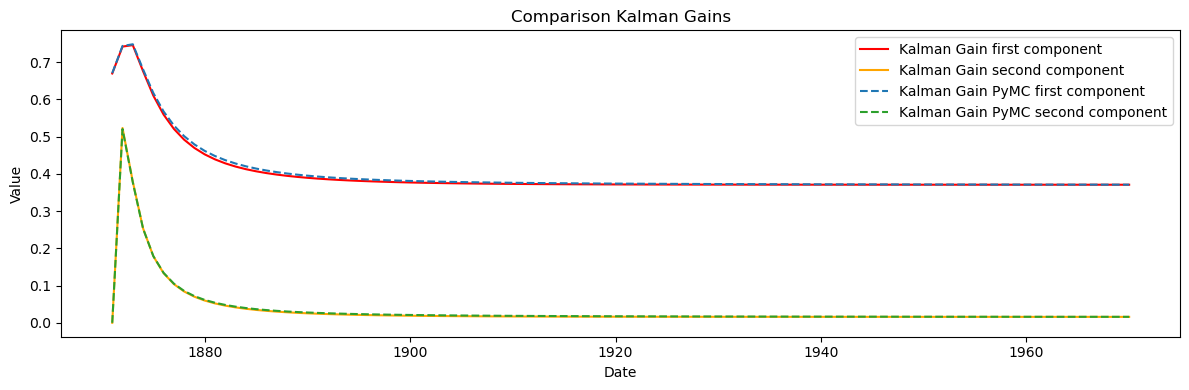

In [73]:

fig, ax = plt.subplots(figsize=(12, 4))

# Plot observed data
ax.plot(nile.index, kalman_gain_comp[:,0], label="Kalman Gain first component", color="red", linewidth=1.5)

# Plot observed data
ax.plot(nile.index, kalman_gain_comp[:,1], label="Kalman Gain second component", color="orange", linewidth=1.5)

# Plot predicted observations
ax.plot(nile.index, kalman_mean_pymc[:,0], label="Kalman Gain PyMC first component", linestyle="--", color="tab:blue")
# Plot predicted observations
ax.plot(nile.index, kalman_mean_pymc[:,1], label="Kalman Gain PyMC second component", linestyle="--", color="tab:green")


# Customize plot
ax.set_title("Comparison Kalman Gains")
ax.set_xlabel("Date")
ax.set_ylabel("Value")
ax.legend()
plt.tight_layout()
plt.show()